In [9]:
import ast
import codecs
from collections import OrderedDict
import re
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine, mahalanobis
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

import artm
from lsh import LSH
from topicnet.cooking_machine.models import TopicModel
from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from utils import (read_collection,  df2vw, compute_pt_distribution, compute_joint_pwt_distribution, 
                   compute_ptw, read_plaintext, tw_vectorized, compute_features_from_pwt2)

# PATH = '/home/grishanovalexey/Projects/lenta/'
PATH = './'

### ПОИСК НОВЫХ ТЕМ В ПОТОКЕ

1) Бэзлайн "5+1": взять 5 разных тэгов `Наука и техника`, `Экономика`, `Культура`, `Ценности`, `Дом` до ДАТЫ (2018 г.). Построить там `model_1` на 5 тем. Добавить в коллекцию новости из этих же тэгов после ДАТЫ + новый тэг после ДАТЫ. Анализировать. Желательно добавлять в различных пропорциях и анализировать полученные результаты. Пытаемся понять, можно ли вообще определить что возникла новая тема.

2) Обучить классификатор, который по документу (из нового батча документов) и ТМ пытается предсказать, есть ли в этом документе новая тема.

Признаки:
- аномально новая лексика (включая нграммы)
- тематический профиль размазан, нет главной темы
- сырые частоты p(w|d) не похожи на то, что было в коллекции раньше
- расстояние до центров тем
- и т.д.?

<img src='img/task.jpg'>

## Исходные данные
На них построим модель

In [32]:
lenta5 = pd.read_csv(PATH + 'data/lenta5_full_preprocessed.csv') # 1000*5
df2vw(lenta5, PATH + 'data/lenta5.vw')

bv_lenta5, dictionary_lenta5 = read_collection(PATH + "data/batches_lenta", PATH + "data/lenta5.vw")

In [577]:
lenta5.head(2)

index                                         url  \
0  514982  https://lenta.ru/news/2007/08/11/galactic/   
1  435891   https://lenta.ru/news/2009/04/03/arabian/   

                                               title  \
0    Первую гостиницу в космосе построят в 2012 году   
1  Арабский девелопер построит шикарный курорт в ...   

                                                text topic tags  \
0  Первую гостиницу в космосе планируется открыть...   Дом  Все   
1  Компания Nakheel Hotels (ОАЭ), входящая в холд...   Дом  Все   

                                          lemmatized  year  month  day  \
0  один гостиница космос планироваться открыть го...  2007      8   11   
1  компания nakheel hotels оаэ входящая холдинг n...  2009      4    3   

   time_n                                            topmine  
0  197815  ['строительство_гостиница', 'япония_и_сша', 's...  
1  276782  ['прежний_высокий', 'реализация_проект', 'учас...

In [169]:
model_1 = artm.ARTM(
    topic_names=['topic {}'.format(i) for i in range(5)],
    theta_columns_naming = 'title',
    num_document_passes = 5,
    class_ids={'lemmatized': 1.0, 'topmine': 1},
    seed=33
    )
    
add_standard_scores(model_1, dictionary_lenta5, modalities=('lemmatized', 'topmine'))
model_1.initialize(dictionary_lenta5)

model_1.regularizers.add(
    artm.DecorrelatorPhiRegularizer(
        name='decorrelator_phi', tau=0.05, gamma=0, class_ids=['lemmatized', 'topmine'])
    )
model_1.fit_offline(batch_vectorizer=bv_lenta5, num_collection_passes=20)

In [146]:
tm = TopicModel(artm_model=model_1, model_id='1')
model_top_tok = TopTokensViewer(tm, num_top_tokens=10, method='blei')
model_top_tok.view()

{'topic 0': {'lemmatized': {'сша': 0.30517008502774307,
   'самолёт': 0.29890964466854986,
   'военный': 0.2904401631974124,
   'российский': 0.27266654628725107,
   'страна': 0.23955391917471539,
   'сообщать': 0.20646205798302672,
   'ракета': 0.2018624781443955,
   'быть': 0.18047794770922473,
   'система': 0.17582641826945433,
   'россия': 0.17139048343473626},
  'topmine': {'министерство_оборона': 0.2208169232501469,
   'сотовый_оператор': 0.10455182832408161,
   'подводный_лодка': 0.10455182832408161,
   'контракт_на_поставка': 0.09993349138004264,
   'новое_поколение': 0.09070710592394793,
   'министерство_культура': 0.08609940248810218,
   'российский_сторона': 0.0837970001226499,
   'южный_корея': 0.08379699290374959,
   'тысяча_тонна': 0.08149559394970271,
   'космический_станция': 0.08149558673399207}},
 'topic 1': {'lemmatized': {'год': 0.7762491048055173,
   'бренд': 0.5225430322766311,
   'коллекция': 0.3760801217174356,
   'компания': 0.36946042579633026,
   'модель': 0.

## Новые данные (с документами из новой темы)

In [ ]:
lenta6 = pd.read_csv(PATH + 'data/lenta6_full_preprocessed.csv') # 200*5 + 1000
df2vw(lenta6, PATH + 'data/lenta6.vw')

bv_lenta6, dictionary_lenta6 = read_collection(PATH + "data/batches_lenta6", PATH + "data/lenta6.vw")

In [578]:
lenta6.head(2)

index                                                url  \
0   3254       https://lenta.ru/news/2018/11/21/stopsnyato/   
1   1200  https://lenta.ru/news/2018/12/06/robbersbehind...   

                                               title  \
0  Москвич пригласил девушку в съемную квартиру и...   
1  Грабившую частные дома банду иностранцев задер...   

                                                text topic      tags  \
0  Житель российской столицы познакомился в интер...   Дом  Квартира   
1  Подмосковные полицейские задержали шестерых гр...   Дом      Дача   

                                          lemmatized  year  month  day  \
0  житель российский столица познакомиться интерн...  2018     11   21   
1  подмосковный полицейский задержать шестеро гра...  2018     12    6   

   time_n                                            topmine  
0  709517  ['летний_москвич', 'задержать_возбудить', 'отн...  
1  711508  ['дом_обнаружить', 'город_киров', 'наказание_в...

# Признаки

In [407]:
main_features = pd.DataFrame()
main_features['target'] = lenta6['topic'] == 'Спорт'
main_features['target'] = main_features['target'].astype('int')

### Гистограммы по вероятностям
Shape: num_topics * 10

In [426]:
ptw = compute_ptw(compute_joint_pwt_distribution(model_1.get_phi(class_ids='lemmatized'), 
                                   compute_pt_distribution(model_1)))
ptw = ptw.transpose()

In [428]:
ptw.head()

topic 0  topic 1       topic 2  topic 3  topic 4
(lemmatized, wil)     0.000000      0.0  1.000000e+00      0.0      0.0
(lemmatized, хенджи)  1.000000      0.0  4.399163e-07      0.0      0.0
(lemmatized, менгир)  0.999999      0.0  8.175100e-07      0.0      0.0
(lemmatized, бойна)   0.999995      0.0  5.259061e-06      0.0      0.0
(lemmatized, хендж)   0.999998      0.0  2.448889e-06      0.0      0.0

In [440]:
phi = model_1.get_phi(class_ids='lemmatized')
theta = model_1.transform(batch_vectorizer=bv_lenta5)
phi_rows = list(phi.index)
phi_rows=list(map(lambda x: x[1], phi_rows))
phi_sort = np.argsort(phi_rows)
theta_cols = list(map(int, theta.columns))

In [446]:
docs_ptw_new = {}
with codecs.open(PATH + 'data/lenta6.vw', "r", encoding="utf8") as f:
    for line in tqdm_notebook(f):
        doc_num, data = read_plaintext(line)
        doc_wt = tw_vectorized(data, phi_val=ptw, phi_rows=phi_rows)
        docs_ptw_new[doc_num] = (doc_wt, data)
        
docs_ptw = {}
with codecs.open(PATH + 'data/lenta5.vw', "r", encoding="utf8") as f:
    for line in tqdm_notebook(f):
        doc_num, data = read_plaintext(line)
        doc_wt = tw_vectorized(data, phi_val=ptw, phi_rows=phi_rows)
        docs_ptw[doc_num] = (doc_wt, data)

In [530]:
docs_pre = list(docs_ptw.keys())
docs_after = list(docs_ptw_new.keys())

In [533]:
# получим вектора признаков

doc_pre_vectors = np.zeros((len(docs_pre), 50))
doc_after_vectors = np.zeros((len(docs_after), 50))

for doc_id, doc in enumerate(docs_pre):
    doc_pre_vectors[doc_id] = compute_features_from_pwt2(docs_ptw, doc)
for doc_id, doc in enumerate(docs_after):
    doc_after_vectors[doc_id] = compute_features_from_pwt2(docs_ptw_new, doc)

In [536]:
topic_for_doc_pre = np.array([0]*1000 + [1]*1000 + [2]*1000 + [3]*1000 + [4]*1000)
topic_for_doc_after = np.array([0]*200 + [1]*200 + [2]*200 + [3]*200 + [4]*200 + [5]*1000)

In [468]:
themes = ['Наука и техника', 'Экономика', 'Культура', 'Ценности', 'Дом']

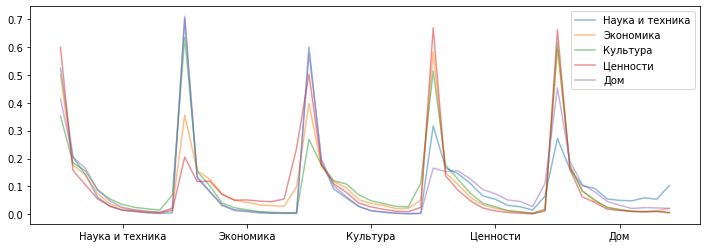

In [537]:
# визуализация центров кластеров

centers = np.zeros((5, 50))
for i in range(5):
    centers[i] = np.mean(doc_pre_vectors[topic_for_doc_pre == i], axis=0)
    
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.plot(range(50), centers[i], alpha=0.5, label=themes[i])
plt.xticks([5, 15, 25, 35, 45], themes)
plt.legend()

In [541]:
# посчитаем расстояние до центров от всех старых документов

distances_to_center_pre = np.zeros((len(docs_pre), 5))

for doc_ind, doc in enumerate(docs_pre):
    for i in range(5):
        distances_to_center_pre[doc_ind, i] =  cosine(doc_pre_vectors[doc_ind], centers[i])

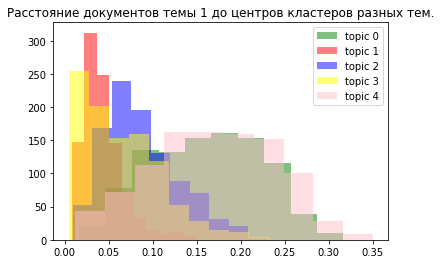

In [545]:
# посмотрим хорошо ли выделяются документы темы 1 по расстоянию

plt.hist(distances_to_center_pre[topic_for_doc_pre == 1][:, 0], color='green', alpha=0.5, label='topic 0')
plt.hist(distances_to_center_pre[topic_for_doc_pre == 1][:, 1], color='red', alpha=0.5, label='topic 1')
plt.hist(distances_to_center_pre[topic_for_doc_pre == 1][:, 2], color='blue', alpha=0.5, label='topic 2')
plt.hist(distances_to_center_pre[topic_for_doc_pre == 1][:, 3], color='yellow', alpha=0.5, label='topic 3')
plt.hist(distances_to_center_pre[topic_for_doc_pre == 1][:, 4], color='pink', alpha=0.5, label='topic 4')
plt.legend()
plt.title('Расстояние документов темы 1 до центров кластеров разных тем.')
plt.show()

In [540]:
# посчитаем расстояния от новых документов до центров кластеров старых документов

distances_to_center_after = np.zeros((len(docs_after), 5))

for doc_ind, doc in enumerate(docs_after):
    for i in range(5):
        distances_to_center_after[doc_ind, i] =  cosine(doc_after_vectors[doc_ind], centers[i])

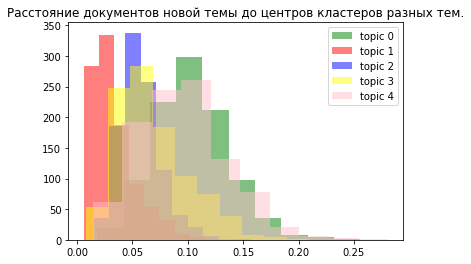

In [544]:
topic = 5
plt.hist(distances_to_center_after[topic_for_doc_after == topic][:, 0], color='green', alpha=0.5, label='topic 0')
plt.hist(distances_to_center_after[topic_for_doc_after == topic][:, 1], color='red', alpha=0.5, label='topic 1')
plt.hist(distances_to_center_after[topic_for_doc_after == topic][:, 2], color='blue', alpha=0.5, label='topic 2')
plt.hist(distances_to_center_after[topic_for_doc_after == topic][:, 3], color='yellow', alpha=0.5, label='topic 3')
plt.hist(distances_to_center_after[topic_for_doc_after == topic][:, 4], color='pink', alpha=0.5, label='topic 4')
plt.legend()
plt.title('Расстояние документов новой темы до центров кластеров разных тем.')
plt.show()

In [543]:
main_features['min_distance_to_center'] = np.min(distances_to_center_after, axis=1)

In [548]:
distances_to_center_after2 = np.sort(distances_to_center_after, axis=1)[:, :2]
distances_to_center_after2 = abs(distances_to_center_after2[:, 0] - distances_to_center_after2[:, 1])
main_features['diff_distance_to_center'] = distances_to_center_after2

### Усреднение принадлежности слов к каждой теме
Shape: num_topics

In [551]:
# средние принадлежности слов темам в документе

features_pre = np.zeros((len(docs_pre), 5))

for doc_ind, doc in enumerate(docs_pre):
    features_pre[doc_ind] = compute_features_from_pwt4(docs_ptw, doc)

In [552]:
features_after = np.zeros((len(docs_after), 5))

for doc_ind, doc in enumerate(docs_after):
    features_after[doc_ind] = compute_features_from_pwt4(docs_ptw_new, doc)

In [ ]:
centers = np.zeros((5, 5))
for i in range(5):
    centers[i] = np.mean(features_pre[topic_for_doc_pre == i], axis=0)

In [554]:
distances_to_center_after = np.zeros((len(docs_after), 5))

for doc_ind, doc in enumerate(docs_after):
    for i in range(5):
        distances_to_center_after[doc_ind, i] =  cosine(features_after[doc_ind], centers[i])

In [555]:
distances_to_center_pre = np.zeros((len(docs_pre), 5))

for doc_ind, doc in enumerate(docs_pre):
    for i in range(5):
        distances_to_center_pre[doc_ind, i] =  cosine(features_pre[doc_ind], centers[i])

In [556]:
main_features['min_dist_to_center2'] = np.min(distances_to_center_after, axis=1)

In [557]:
# разница между расстояниями до двух ближайших центров  
distances_to_center_after2 = np.sort(distances_to_center_after)[:, :2]
distances_to_center_after2 = abs(distances_to_center_after2[:, 0] - distances_to_center_after2[:, 1])

In [558]:
main_features['diff_distance_to_center2'] = distances_to_center_after2

In [542]:
main_features.to_csv('data/features.csv', index=False)

# Модель

In [572]:
dt = DecisionTreeClassifier(random_state=16, max_depth=4)

X_train, X_test, y_train, y_test = train_test_split(main_features.drop(['target'], axis=1).values, 
                                                    main_features['target'].values, 
                                                    stratify=main_features['target'].values, 
                                                    test_size=0.3, random_state=16)

In [573]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=16, splitter='best')

In [585]:
accuracy_score(y_test, dt.predict(X_test))

0.7566666666666667